In [1]:
import tensorflow as tf

print(tf.__version__)
for device in tf.config.list_physical_devices():
    print(device)

2.7.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [3]:
EPOCHS = 100
Z_DIM = 100
BATCH_SIZE = 128
BUFFER_SIZE = 60000
IMAGE_SIZE = 28 * 28
IMAGE_SHAPE = (28, 28, 1)
D_LR = 0.0004
G_LR = 0.0004

In [4]:
# get sample z from prior
def get_random_z(batch_size, z_dim):
    return tf.random.normal(shape=(batch_size, z_dim))
    # อย่าลืมที่แนะนำว่า input value ค่าอยู่ระหว่าง [-1, 1]

In [5]:
# define discriminator
def make_discriminator(input_shape, name='discriminator'):
    return tf.keras.Sequential([
        layers.Input(shape=IMAGE_SHAPE), # รับ input เป็นภาพเลย (28, 28, 1) อย่าลืม 1 ข้างหลังสุด
        layers.Flatten(),
        layers.Dense(units=256, activation=None, input_shape=input_shape), # จริงๆคือ layers แรก
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256, activation=None),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(units=1, activation=None)
    ], name=name)

test_D = make_discriminator(input_shape=(IMAGE_SIZE,))
test_D.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 267,009
Trainable params: 267,009
Non-t

In [6]:
# define generator
def make_generator(input_shape, name='generator'):
    return tf.keras.Sequential([
        layers.Dense(units=256, activation='relu', input_shape=input_shape),
        layers.Dense(units=256, activation='relu'),
        layers.Dense(units=IMAGE_SIZE, activation='tanh'),
        layers.Reshape(IMAGE_SHAPE)
    ], name=name)

test_G = make_generator(input_shape=(Z_DIM,))
test_G.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 293,136
Trainable params: 293,136
Non-trainable params: 0
_________________________________________________________________


(1, 28, 28, 1)


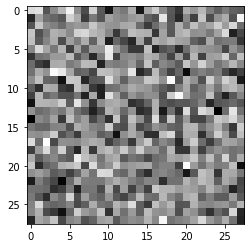

In [7]:
test_z = get_random_z(1, 100)
test_gen_img = test_G(test_z, training=False).numpy()
print(test_gen_img.shape)
plt.imshow(
    test_gen_img.reshape((28, 28, -1)),
    cmap='binary')
plt.show()

In [8]:
# test = np.random.normal(size=(100, 1))
# tf.ones_like(test)

In [9]:
# define loss
def get_loss_fn():

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def d_loss_fn(real_logits, fake_logits):
        real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
        fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
        return real_loss + fake_loss
    
    def g_loss_fn(fake_logits):
        return cross_entropy(tf.ones_like(fake_logits), fake_logits)

    return d_loss_fn, g_loss_fn

In [10]:
(train_x, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_x = train_x.reshape((-1, 28, 28, 1))
print(train_x.shape)

(60000, 28, 28, 1)


In [11]:
train_x = (train_x - 127.5) / 127.5
train_x = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
)

In [12]:
# generator & discriminator
G = make_generator(input_shape=(Z_DIM,))
D = make_discriminator(input_shape=(IMAGE_SIZE,))

# optimizer
g_optim = tf.keras.optimizers.Adam(learning_rate=G_LR)
d_optim = tf.keras.optimizers.Adam(learning_rate=D_LR)

# loss function
d_loss_fn, g_loss_fn = get_loss_fn()

#seed
num_sample_img = 16
seed = get_random_z(num_sample_img, Z_DIM)

In [13]:
@tf.function
def train_step(real_images):
    
    z = get_random_z(batch_size=BATCH_SIZE, z_dim=Z_DIM)
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        # produce fake images
        fake_images = G(z, training=True)

        # discriminator try to predict
        fake_logits = D(fake_images, training=True)
        real_logits = D(real_images, training=True)

        d_loss = d_loss_fn(real_logits, fake_logits)
        g_loss = g_loss_fn(fake_logits)

    d_gradients = d_tape.gradient(d_loss, D.trainable_variables)
    g_gradients = g_tape.gradient(g_loss, G.trainable_variables)

    d_optim.apply_gradients(zip(d_gradients, D.trainable_variables))
    g_optim.apply_gradients(zip(g_gradients, G.trainable_variables))

    return d_loss, g_loss

In [14]:
# training loop
D_losses = list()
G_losses = list()
def train(dataset, epochs=EPOCHS):

    print("start training..")

    for epoch in range(epochs):
        
        print(f"At epochs : {epoch}...")
        for iteration, real_images in enumerate(dataset):

            d_loss, g_loss = train_step(real_images)

            if iteration % 20 == 0:
                D_losses.append(d_loss)
                G_losses.append(g_loss)
            
        display.clear_output(wait=True)
        print(f'At end of epoch:{epoch}, D-loss={d_loss} | G-loss={g_loss}')
        generate_and_save_images(G, epoch + 1, seed)
        
    display.clear_output(wait=True)
    print(f'At end of epoch:{epoch}, D-loss={d_loss} | G-loss={g_loss}')
    generate_and_save_images(G, epoch + 1, seed)      

In [15]:
def generate_and_save_images(generator, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = generator(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('fakeimage/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

At end of epoch:99, D-loss=1.0821943283081055 | G-loss=1.7338894605636597


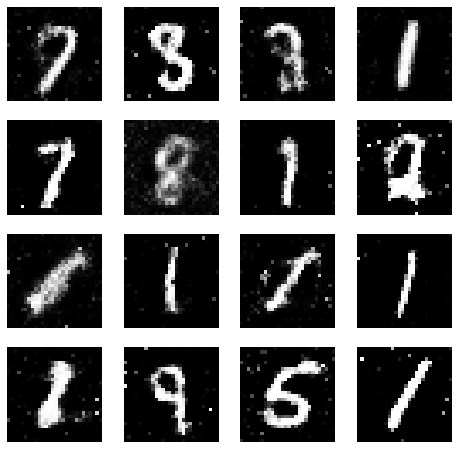

In [16]:
train(train_x)

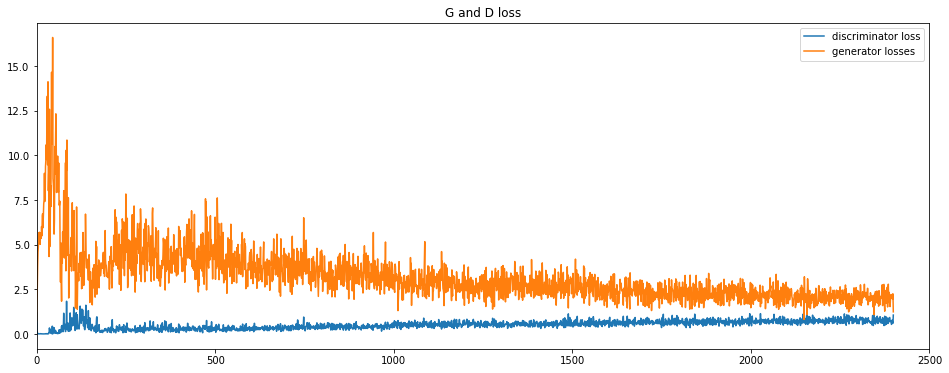

In [23]:
fig = plt.figure(figsize=(16, 6))
plt.plot(D_losses, label='discriminator loss')
plt.plot(G_losses, label='generator losses')
plt.title("G and D loss")
plt.legend()
plt.xlim((0, 2500))
plt.show()